In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/acea-water-prediction/Aquifer_Doganella.csv
/kaggle/input/acea-water-prediction/Aquifer_Auser.csv
/kaggle/input/acea-water-prediction/Water_Spring_Amiata.csv
/kaggle/input/acea-water-prediction/datasets_description.ods
/kaggle/input/acea-water-prediction/Lake_Bilancino.csv
/kaggle/input/acea-water-prediction/datasets_description.xlsx
/kaggle/input/acea-water-prediction/Water_Spring_Madonna_di_Canneto.csv
/kaggle/input/acea-water-prediction/Aquifer_Luco.csv
/kaggle/input/acea-water-prediction/Aquifer_Petrignano.csv
/kaggle/input/acea-water-prediction/Water_Spring_Lupa.csv
/kaggle/input/acea-water-prediction/River_Arno.csv


In [2]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

dir="/kaggle/input/acea-water-prediction/"
source = "River_Arno.csv"
data = pd.read_csv(dir+source)


# Preprocssing
* Drop the NA rows
* Parse Date into year, month, day.

In [3]:
df = data.dropna().reset_index()
df['date'] = df['Date'].apply(lambda x: datetime.strptime(x, "%d/%m/%Y"))
y = df.iloc[0]['date'].year
df['year-month'] = df['date'].apply(lambda x: int((x.year-y)*12+x.month))
df['year'] = df['date'].apply(lambda x: int(x.year))
df['month'] = df['date'].apply(lambda x: int(x.month))
df['day'] = df['date'].apply(lambda x: int(x.day))

# Feature Engineering
We create 2 columns by computing the mean and standard deviation for all the rainfall columns

In [4]:
import numpy as np
df['rainfall-avg'] = df[[ f for f in df.columns if f.startswith('Rain')]].apply(lambda x: x.mean(), axis=1)
df['rainfall-std'] = df[[ f for f in df.columns if f.startswith('Rain')]].apply(lambda x: np.std(x, axis=0), axis=1)



We found that only using the average and standard deviation may not be good enough to summarize, we do the PCA analysis to summarize and reduce the dimension. The first 2 PCA components already explained 82.0% of variance.


The first 2 PCA components already explained 82.0% of variance.


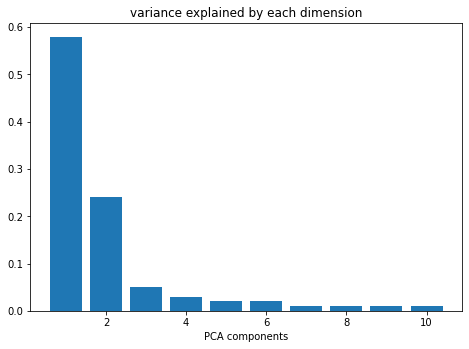

In [5]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

X = df[[ f for f in df.columns if f.startswith('Rain')]]
k = 10
pca = PCA(n_components=k)
pca.fit(X)
v = pca.explained_variance_ratio_.round(2)
print("The first 2 PCA components already explained {}% of variance.".format((v[0]+v[1])*100))
ax.bar(range(1,k+1),v)
plt.xlabel("PCA components")
plt.title("variance explained by each dimension")
plt.show()


# PCA Analysis
We perform PCA analysis on all the rainfall columns.  The above bar chart showed the first 2 components already explained over 80% of the variance.  Therefore, we can use PCA1 and PCA2 to represent all the rainfall.

In [6]:
from sklearn.decomposition import PCA
X = df[[ f for f in df.columns if f.startswith('Rain')]]
X_reduced = PCA(n_components=2).fit_transform(X)
pf = pd.DataFrame(X_reduced, columns=['PCA1','PCA2'])
df['PCA1'] = pf['PCA1']
df['PCA2'] = pf['PCA2']

# Clustering Plot
The key 3 features are PCA1 and PCA2 of rainfall, and the Temperature_Firenze.  We plotted the 3D scatter using the 3 key features, and the target value (Hydrometry_Nave_di_Rosano) is shown in the color.  We can see how good the key features to separate the target values.

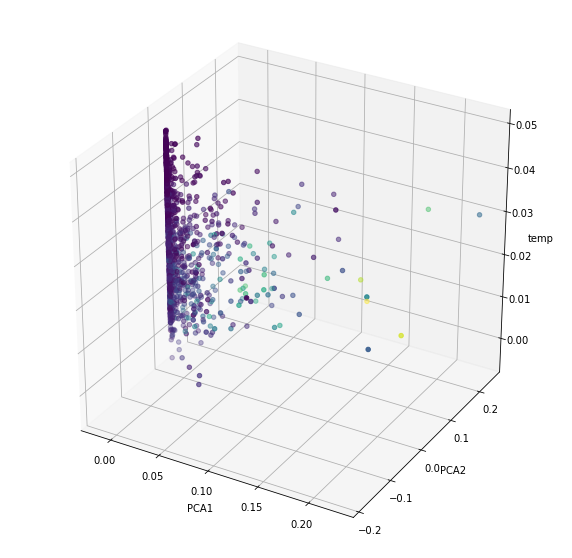

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn import preprocessing
fig = plt.figure(1,(10,10))
#ax = fig.subplots()
ax = fig.add_subplot(111, projection='3d')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
ax.set_zlabel('temp')
xval = preprocessing.normalize([np.array(df['PCA1'])])
yval = preprocessing.normalize([np.array(df['PCA2'])])
zval = preprocessing.normalize([np.array(df['Temperature_Firenze'])])
#zval = preprocessing.normalize([np.array(df['PCA12'])])
ax.scatter(xval,yval,zval,
               c=df['Hydrometry_Nave_di_Rosano'])

# Linearity Analysis
The above scatter plot showed that the purple dots and blues dot are mixed together, that means the 3 key features could not well determine the target values.  That indicates that the target variable is not linearly depends on the featuers.  Therefore, we use the quadratic relations of PCA1 and PCA2 as the new features.  3 new feaures are: {PCA1}^2, {PCA2}^2, and PCA1 * PCA2.

In [8]:
df['PCA11'] = pf['PCA1']*pf['PCA1']
df['PCA22'] = pf['PCA2']*pf['PCA2']
df['PCA12'] = pf['PCA1']*pf['PCA2']

The scatter plot below showed the relation of {PCA1}^2, {PCA2}^2, and temperature against the target variable.  We can see the purple dots and blue dots are grouped more dense than the previous plot.  That means the quadratic new features would be better to determine the target variable.

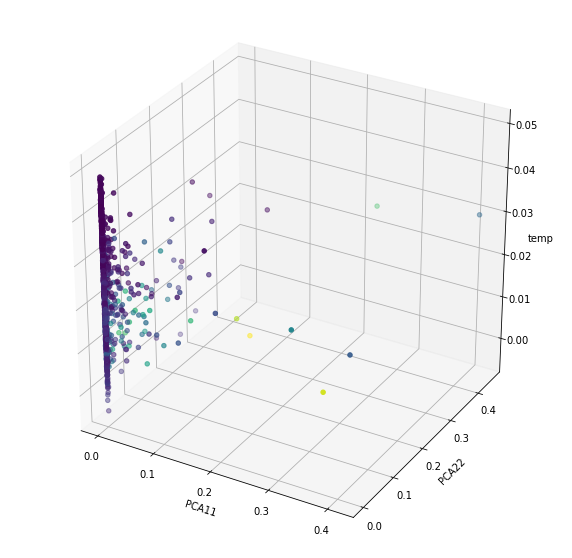

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn import preprocessing
fig = plt.figure(1,(10,10))
#ax = fig.subplots()
ax = fig.add_subplot(111, projection='3d')
plt.xlabel('PCA11')
plt.ylabel('PCA22')
ax.set_zlabel('temp')
xval = preprocessing.normalize([np.array(df['PCA11'])])
yval = preprocessing.normalize([np.array(df['PCA22'])])
zval = preprocessing.normalize([np.array(df['Temperature_Firenze'])])
#zval = preprocessing.normalize([np.array(df['PCA12'])])
ax.scatter(xval,yval,zval,
               c=df['Hydrometry_Nave_di_Rosano'])

# Time Series Analysis
We believe the target variable (Hydrometry_Nave_di_Rosano) would be a time series with seasonality of year.  We plotted the target value for each year.  We use the rolling average to smooth the fluctuation.  We overlay the values of the year 2004 to year 2006.  The 3 curvers showed similar pattern.

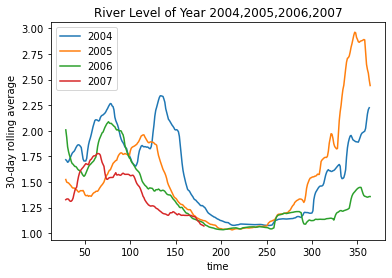

In [10]:
plt.title("River Level of Year 2004,2005,2006,2007")
plt.xlabel("time")
plt.ylabel("30-day rolling average")
plt.plot(df[df.year == 2004]['Hydrometry_Nave_di_Rosano'].reset_index(drop=True).rolling(30).mean(),label="2004")
plt.plot(df[df.year == 2005]['Hydrometry_Nave_di_Rosano'].reset_index(drop=True).rolling(30).mean(),label="2005")
plt.plot(df[df.year == 2006]['Hydrometry_Nave_di_Rosano'].reset_index(drop=True).rolling(30).mean(),label="2006")
plt.plot(df[df.year == 2007]['Hydrometry_Nave_di_Rosano'].reset_index(drop=True).rolling(30).mean(),label="2007")
plt.legend()

We plotted the monthly average over all the year to show the pattern more clear.  We can see the peak at March and December, and the bottom at July.  This pattern repeat very year.  Therefore, month will be a very important feature.

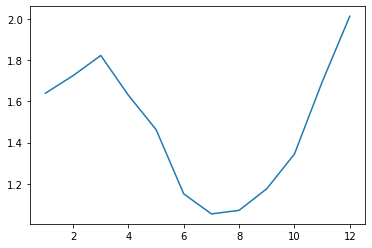

In [11]:
x = df.groupby('month').agg({'Hydrometry_Nave_di_Rosano': 'mean'})
plt.plot(x)

Yearly Average River level is dropping

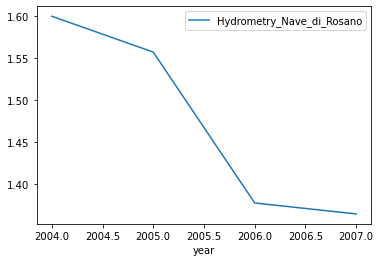

In [12]:
ym = df.groupby('year').agg({'Hydrometry_Nave_di_Rosano': 'mean'})
ym.plot()

# What if we de-trend the river level with the year-mean?
The river level of each year overlap more.  The monthly pattern is more obvious.

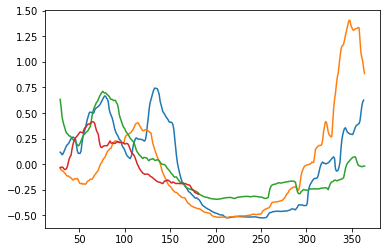

In [13]:
a = df.merge(ym.reset_index(),on='year')
a['diff-year-mean'] = a[['Hydrometry_Nave_di_Rosano_x','Hydrometry_Nave_di_Rosano_y']].apply(lambda x: x['Hydrometry_Nave_di_Rosano_x'] - x['Hydrometry_Nave_di_Rosano_y'], axis=1)
tgt = 'diff-year-mean'
plt.plot(a[a.year == 2004][tgt].reset_index(drop=True).rolling(30).mean(),label="2004" )
plt.plot(a[a.year == 2005][tgt].reset_index(drop=True).rolling(30).mean(),label="2005" )
plt.plot(a[a.year == 2006][tgt].reset_index(drop=True).rolling(30).mean(),label="2006" )
plt.plot(a[a.year == 2007][tgt].reset_index(drop=True).rolling(30).mean(),label="2007" )

# Stationary Time Series
Here we would like to verify whether the monthly-average as a time series is stationary or not.  We do the Adfuller test, and plot the ACF and PACF.  The ADF statistics are more negative than 5%-critical value, and the p-value < 0.05.  So it is statinary.

The ACF and PACF plot showed that we can use ARIMA to simulate the time series.  The AR and MA terms can be determined by the ACF and PACF plot.  We will use ARIMA(4,0,2).

ADF Statistic: -3.334514
p-value: 0.013404
Critical Values:
	1%: -3.601
	5%: -2.935
	10%: -2.606


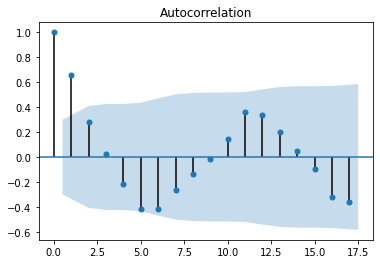

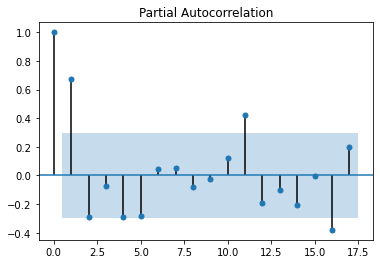

In [14]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller

X = df.groupby('year-month').agg({'Hydrometry_Nave_di_Rosano': 'mean'})

result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))
    
plot_acf(X)
plot_pacf(X)
plt.show()

# ARIMA
With ARIMA we can simulate the monthly average.  We use the first year data to train the ARIMA, and then make the forecast the value of next year.  Then we repeat by training with the data of the previous year, and predict the data for the next year.

The MAE is 0.46,and MSE is 0.3

In [15]:
import warnings
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import numpy as np
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    t = int(len(X)/12)
    x_train = X[:12]
    model = ARIMA(x_train, order=(4,0,2))
    model_fit = model.fit()
    predictions = np.array([])
    for i in range(t-1):
        x_train = X[12*i:12*(i+1)]
        model = ARIMA(x_train, order=(4,0,2))
        model_fit = model.fit()
        output = model_fit.forecast(steps=12)
        predictions = np.append(predictions,output.values)

    n = min( len(predictions), len(X) -12 )
    print("mae =",mean_absolute_error(X[12:12+n], predictions[:n]) ) 
    print("mse =",mean_squared_error(X[12:12+n], predictions[:n])) 

mae = 0.4585016332745508
mse = 0.30103645134076995


We plotted the ARIMA forecast with the target, it showed that the model can only partially fit the actual value.  It is because time series is not the only factor.

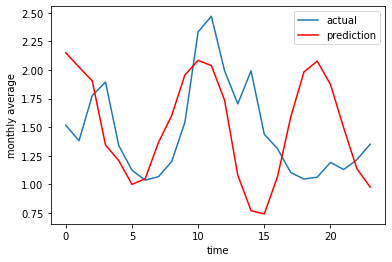

In [16]:
plt.xlabel("time")
plt.ylabel("monthly average")
plt.plot(range(n),X[12:12+n],label="actual")
plt.plot(range(n),predictions[:n], color='red',label='prediction')
plt.legend()

# Regression
We tried to combined all the features including the PCA features, temperature, and the month (time series feature) to predict the target variable using the regression.  We also believe that the rainfall and temperature will not affect the target immediately, we repeat the same regression with up-to 30 days of future target values.  We create new target columns by using the shift(0) to shift(-30) on the target variable (Hydrometry_Nave_di_Rosano).

In [17]:
for i in range(0,31):
    df['label-next-'+str(i)] = df['Hydrometry_Nave_di_Rosano'].shift(-1*i)
df

,index,Date,Rainfall_Le_Croci,Rainfall_Cavallina,Rainfall_S_Agata,Rainfall_Mangona,Rainfall_S_Piero,Rainfall_Vernio,Rainfall_Stia,Rainfall_Consuma,...,label-next-21,label-next-22,label-next-23,label-next-24,label-next-25,label-next-26,label-next-27,label-next-28,label-next-29,label-next-30
0,2191,01/01/2004,0.0,0.0,0.4,0.0,0.0,0.0,0.0,0.0,...,1.92,1.91,1.60,1.44,1.53,1.63,1.70,1.80,1.84,1.58
1,2192,02/01/2004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.91,1.60,1.44,1.53,1.63,1.70,1.80,1.84,1.58,1.46
2,2193,03/01/2004,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,...,1.60,1.44,1.53,1.63,1.70,1.80,1.84,1.58,1.46,1.77
3,2194,04/01/2004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.44,1.53,1.63,1.70,1.80,1.84,1.58,1.46,1.77,1.98
4,2195,05/01/2004,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,...,1.53,1.63,1.70,1.80,1.84,1.58,1.46,1.77,1.98,2.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1271,3469,02/07/2007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1272,3470,03/07/2007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1273,3471,04/07/2007,0.0,0.0,0.8,1.0,0.0,0.8,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1274,3472,05/07/2007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# PyCaret
We use the AutoML package PyCaret to compare different regression models and tune the hyperparameters.

In [18]:
!pip install pycaret

     |████████████████████████████████| 249 kB 4.5 MB/s 
     |████████████████████████████████| 14.1 MB 48.3 MB/s 
     |████████████████████████████████| 1.1 MB 27.9 MB/s 
     |████████████████████████████████| 339 kB 47.7 MB/s 
     |████████████████████████████████| 125 kB 42.2 MB/s 
     |████████████████████████████████| 54 kB 1.6 MB/s 
     |████████████████████████████████| 77 kB 3.7 MB/s 
     |████████████████████████████████| 84 kB 1.9 MB/s 
     |████████████████████████████████| 45 kB 2.0 MB/s 
     |████████████████████████████████| 239 kB 51.8 MB/s 
     |████████████████████████████████| 594 kB 54.2 MB/s 
     |████████████████████████████████| 98 kB 5.0 MB/s 
     |████████████████████████████████| 61 kB 4.9 MB/s 
     |████████████████████████████████| 285 kB 54.1 MB/s 
     |████████████████████████████████| 2.1 MB 36.5 MB/s 
     |████████████████████████████████| 3.1 MB 24.9 MB/s 
     |████████████████████████████████| 72 kB 617 kB/s 
     |██████████████████████

The function cmp will run PyCaret regression models on the t+i Hydrometry_Nave_di_Rosano as the target.  We compared the MAE for each round.  We reserved about 50% of unseen data for testing.  We use the year as the division line to preserve the yearly pattern.

In [19]:
from pycaret.regression import * 
def cmp(i,df):
    features = ['PCA1','PCA2','PCA11','PCA22','PCA12','Temperature_Firenze','month']
    tgt = 'label-next-'+str(i)
    label = [tgt]
    print(features + label)
    y0 = int(df.iloc[0]['date'].year)
    print(y0)
    y1 = int(df.iloc[-1]['date'].year)
    print(y1)
    print(y1-y0)
    t=(y1-y0)/2
    print(t)

    df = df.ffill().bfill()
    x_train = df[df.year <= y0+t][features + label]
    x_test = df[df.year > y0+t][features + label]
    print(x_train.size,x_test.size)


    if i == 0:
        x_train.to_csv('xtrain.csv', index=False)
        x_test.to_csv('xtest.csv', index=False)
        

    exp_reg = setup(data = x_train, target = tgt, session_id=123, silent=True,
                    normalize = True, 
                    transformation = True, 
                    ignore_low_variance = True,
                    log_experiment=True, experiment_name='river')
    best_model = compare_models()
    return (best_model,x_test,tgt)

In [20]:
from pycaret.regression import * 
from sklearn.metrics import mean_absolute_error
results = []
for i in range(0,31):
    (best_model,x_test,tgt) = cmp(i,df)
    print(best_model)
    predictions = predict_model(best_model, data = x_test)
    e = mean_absolute_error(predictions[tgt], predictions['Label'])
    rs = {"next":str(i), "mae": e}
    results.append(rs)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,0.3082,0.2465,0.4876,0.2913,0.1569,0.1748,0.4440
huber,Huber Regressor,0.2753,0.2798,0.5074,0.2774,0.1568,0.1331,0.0320
br,Bayesian Ridge,0.3182,0.2692,0.5052,0.2651,0.1582,0.1734,0.0170
ridge,Ridge Regression,0.3163,0.2672,0.5039,0.2646,0.1582,0.1719,0.0140
lr,Linear Regression,0.3179,0.2673,0.5044,0.2609,0.1587,0.1734,0.0150
gbr,Gradient Boosting Regressor,0.3116,0.2577,0.4967,0.2497,0.1576,0.1744,0.0680
knn,K Neighbors Regressor,0.3074,0.2697,0.5091,0.2295,0.1621,0.1703,0.0400
catboost,CatBoost Regressor,0.3196,0.2748,0.5132,0.2177,0.1644,0.1806,2.2160
et,Extra Trees Regressor,0.3093,0.2712,0.5137,0.1945,0.1634,0.1747,0.3760
omp,Orthogonal Matching Pursuit,0.3578,0.3087,0.5380,0.1759,0.1728,0.2044,0.0120


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=123, verbose=0, warm_start=False)


# Comparison Result

We plotted the MAE over different target-lag.  The lowest MAE acheived when we use the features to predict the t+28 Hydrometry_Nave_di_Rosano value.  That means the rainfall and temperature has 4-week defer effect on the target variable.


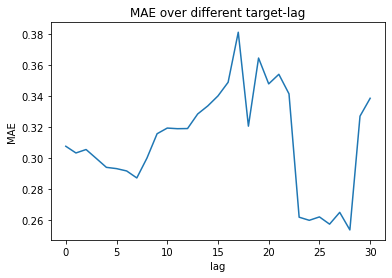

In [21]:
results = pd.DataFrame(results,columns=['next','mae'])
plt.title("MAE over different target-lag")
plt.ylabel("MAE")
plt.xlabel('lag')
plt.plot(results['mae'])

# HuberRegressor
Run the compare model on t+28 again, and compute the MAE and MSE for the unseen testing data.
HuberRegressor(alpha=0.0001, epsilon=1.35, fit_intercept=True, max_iter=100,
               tol=1e-05, warm_start=False)
mae = 0.2535095932318654
mse = 0.12915030941674246

In [22]:
from pycaret.regression import * 
from sklearn.metrics import mean_absolute_error
(best_model,x_test,tgt) = cmp(28,df)
print(best_model)
predictions = predict_model(best_model, data = x_test)

mean_absolute_error(predictions[tgt], predictions['Label'])
print("mae =",mean_absolute_error(predictions[tgt], predictions['Label']))
print("mse =",mean_squared_error(predictions[tgt], predictions['Label']))

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
huber,Huber Regressor,0.2753,0.2845,0.4936,0.3081,0.1520,0.1341,0.0190
br,Bayesian Ridge,0.3149,0.2808,0.4993,0.2543,0.1563,0.1712,0.0150
ridge,Ridge Regression,0.3127,0.2793,0.4989,0.2514,0.1563,0.1694,0.0120
lr,Linear Regression,0.3134,0.2794,0.4995,0.2477,0.1567,0.1701,0.0140
rf,Random Forest Regressor,0.3138,0.2790,0.5067,0.2233,0.1603,0.1747,0.3390
lightgbm,Light Gradient Boosting Machine,0.3313,0.2929,0.5165,0.1932,0.1645,0.1843,0.0330
gbr,Gradient Boosting Regressor,0.3162,0.2804,0.5106,0.1779,0.1604,0.1763,0.0580
knn,K Neighbors Regressor,0.3184,0.3091,0.5280,0.1719,0.1666,0.1751,0.0380
catboost,CatBoost Regressor,0.3184,0.2924,0.5206,0.1695,0.1640,0.1765,1.8340
omp,Orthogonal Matching Pursuit,0.3553,0.3199,0.5350,0.1544,0.1712,0.2017,0.0100


HuberRegressor(alpha=0.0001, epsilon=1.35, fit_intercept=True, max_iter=100,
               tol=1e-05, warm_start=False)
mae = 0.2535123706737975
mse = 0.1291515983724954


# Hyperparameter tuning
We run tune_model of PyCaret to automate the hyperparameter tuning.

The outcome is: HuberRegressor(alpha=0.01, epsilon=1.1, fit_intercept=True, max_iter=100,
               tol=1e-05, warm_start=False)
              
 
               

In [23]:
tuned_model = tune_model(best_model, optimize = 'MAE')
print(tuned_model)
evaluate_model(tuned_model)

,Parameters
alpha,0.01
epsilon,1.1
fit_intercept,True
max_iter,100
tol,1e-05
warm_start,False


# Feature Importance
On evaluate the model, we can show the feature importance.  The month value is the most important as we showned the target time series follows yearly pattern, so value at each month would be similar for each year.  Following is the temperature, and then the PCA values of the rainfall.
1. Month
1. Temperature
1. PCA of Rainfall

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.2762,0.3144,0.5607,0.1865,0.1677,0.1246
1,0.3017,0.2693,0.5189,0.4110,0.1575,0.1487
2,0.2025,0.1732,0.4162,0.3426,0.1322,0.1054
3,0.3218,0.3550,0.5958,0.2255,0.1759,0.1460
4,0.5306,0.9331,0.9660,0.0163,0.2671,0.1891
5,0.2303,0.1284,0.3583,0.4612,0.1205,0.1255
6,0.1585,0.0736,0.2712,0.5912,0.0974,0.0893
7,0.2287,0.1253,0.3540,0.4254,0.1154,0.1370
8,0.1685,0.0618,0.2486,0.3760,0.0925,0.1100
9,0.3060,0.4162,0.6451,0.0740,0.1953,0.1361


mae = 0.24766170435251178
mse = 0.12751560108050797


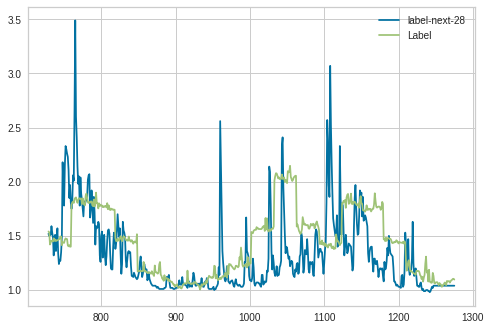

In [24]:
tuned_model = tune_model(best_model, optimize = 'MAE')
predictions = predict_model(tuned_model, data = x_test)
predictions[[tgt,'Label']].plot()
print("mae =",mean_absolute_error(predictions[tgt], predictions['Label']))
print("mse =",mean_squared_error(predictions[tgt], predictions['Label']))

# Prediction
The green line is the predicted value, and the blue line is the actual value.  The prediction can fit the actual value well, although some of the spikes are difficult to predict.

The overall MAE and MSE are better than ARIMA.
mae = 0.24766671464043138
mse = 0.12752131418492915

# LSTM
Because of the lagging effect (t+28 days), we can make use the LSTM network to model the historical effect.  We just simply use a 2-layer LSTM with tiem sequence of 28 days.

Previously we save the training set and testing set into csv files.  We use PyTorch to build the LSTM and the dataloader.
Below is the PyTorch modules for the training and the testing result of the unseen testing data.

In [25]:
!pip install pytorch-lightning

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


# Import PyTorch libraries

In [26]:
from time import time

import numpy as np
import pandas as pd

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# Neural Networks
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.loggers.csv_logs import CSVLogger

# Plotting
import matplotlib.pyplot as plt

# Build Time Series Dataset

In [27]:
class TimeseriesDataset(Dataset):
    '''
    Custom Dataset subclass.
    Serves as input to DataLoader to transform X
      into sequence data using rolling window.
    DataLoader using this dataset will output batches
      of `(batch_size, seq_len, n_features)` shape.
    Suitable as an input to RNNs.
    '''
    def __init__(self, X: np.ndarray, y: np.ndarray, seq_len: int = 1):
        self.X = torch.tensor(X).float()
        self.y = torch.tensor(y).float()
        self.seq_len = seq_len

    def __len__(self):
        return self.X.__len__() - (self.seq_len-1)

    def __getitem__(self, index):
        return (self.X[index:index+self.seq_len], self.y[index+self.seq_len-1])

# Read CSV and build DataLoader

In [28]:
!ls *csv
!pwd

xtest.csv  xtrain.csv
/kaggle/working


In [29]:
class MyDataModule(pl.LightningDataModule):
    '''
    PyTorch Lighting DataModule subclass:
    https://pytorch-lightning.readthedocs.io/en/latest/datamodules.html

    Serves the purpose of aggregating all data loading
      and processing work in one place.
    '''

    def __init__(self, seq_len=1, batch_size=128, num_workers=0):
        super().__init__()
        self.seq_len = seq_len
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.X_train = None
        self.y_train = None
        self.X_val = None
        self.y_val = None
        self.X_test = None
        self.X_test = None
        self.columns = None
        self.preprocessing = None
        self.testsize = 0

    def prepare_data(self):
        pass

    def setup(self, stage=None):

        if stage == 'fit' and self.X_train is not None:
            return
        if stage == 'test' and self.X_test is not None:
            return
        if stage is None and self.X_train is not None and self.X_test is not None:
            return

        dir="/kaggle/input/acea-water-prediction/"
        source = "River_Arno.csv"
        data = pd.read_csv(dir+source)
        df = data.dropna().reset_index()
        df['date'] = df['Date'].apply(lambda x: datetime.strptime(x, "%d/%m/%Y"))
        y = df.iloc[0]['date'].year
        df['year-month'] = df['date'].apply(lambda x: int((x.year-y)*12+x.month))
        df['year'] = df['date'].apply(lambda x: int(x.year))
        df['month'] = df['date'].apply(lambda x: int(x.month))
        df['day'] = df['date'].apply(lambda x: int(x.day))
        df['rainfall-avg'] = df[[ f for f in df.columns if f.startswith('Rain')]].apply(lambda x: x.mean(), axis=1)
        df['rainfall-std'] = df[[ f for f in df.columns if f.startswith('Rain')]].apply(lambda x: np.std(x, axis=0), axis=1)

        X = df[[ f for f in df.columns if f.startswith('Rain')]]
        X_reduced = PCA(n_components=2).fit_transform(X)
        pf = pd.DataFrame(X_reduced, columns=['PCA1','PCA2'])
        df['PCA1'] = pf['PCA1']
        df['PCA2'] = pf['PCA2']
        df['PCA11'] = pf['PCA1']*pf['PCA1']
        df['PCA22'] = pf['PCA2']*pf['PCA2']
        df['PCA12'] = pf['PCA1']*pf['PCA2']

        features = ['PCA1','PCA2','PCA11','PCA22','PCA12','Temperature_Firenze','month']
        tgt = 'Hydrometry_Nave_di_Rosano'
        label = [tgt]
        print(features + label)
        y0 = int(df.iloc[0]['date'].year)
        print(y0)
        y1 = int(df.iloc[-1]['date'].year)
        print(y1)
        print(y1-y0)
        t=(y1-y0)/2
        print(t)

        df = df.ffill().bfill()
        xtrain = df[df.year <= y0+t][features + label]
        xtest = df[df.year > y0+t][features + label]
        print(x_train.size,x_test.size)

        features = xtrain.columns[:-1]
        label = xtrain.columns[-1]
        X_train = xtrain.iloc[:-365]
        X_val = xtrain.iloc[-365:]

        if stage == 'fit' or stage is None:
            self.X_train = X_train[features].values
            self.y_train = X_train[label].values.reshape((-1, 1))
            self.X_val = X_val[features].values
            self.y_val = X_val[label].values.reshape((-1, 1))

        if stage == 'test' or stage is None:
            self.X_test = xtest[features].values
            self.y_test = xtest[label].values.reshape((-1, 1))

    def train_dataloader(self):
        train_dataset = TimeseriesDataset(self.X_train,
                                          self.y_train,
                                          seq_len=self.seq_len)
        train_loader = DataLoader(train_dataset,
                                  batch_size=self.batch_size,
                                  shuffle=False,
                                  num_workers=self.num_workers)

        return train_loader

    def val_dataloader(self):
        val_dataset = TimeseriesDataset(self.X_val,
                                        self.y_val,
                                        seq_len=self.seq_len)
        val_loader = DataLoader(val_dataset,
                                batch_size=self.batch_size,
                                shuffle=False,
                                num_workers=self.num_workers)

        return val_loader

    def test_dataloader(self):
        test_dataset = TimeseriesDataset(self.X_test,
                                         self.y_test,
                                         seq_len=self.seq_len)
        self.testsize = len(test_dataset)
        test_loader = DataLoader(test_dataset,
                                 batch_size=self.batch_size,
                                 shuffle=False,
                                 num_workers=self.num_workers)

        return test_loader


# LSTM RNN module

In [30]:
class LSTMRegressor(pl.LightningModule):
    '''
    Standard PyTorch Lightning module:
    https://pytorch-lightning.readthedocs.io/en/latest/lightning_module.html
    '''

    def __init__(self,
                 n_features,
                 hidden_size,
                 seq_len,
                 batch_size,
                 num_layers,
                 dropout,
                 learning_rate,
                 criterion):
        super(LSTMRegressor, self).__init__()
        self.n_features = n_features
        self.hidden_size = hidden_size
        self.seq_len = seq_len
        self.batch_size = batch_size
        self.num_layers = num_layers
        self.dropout = dropout
        self.criterion = criterion
        self.learning_rate = learning_rate

        self.lstm = nn.LSTM(input_size=n_features,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            dropout=dropout,
                            batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # lstm_out = (batch_size, seq_len, hidden_size)
        lstm_out, _ = self.lstm(x)
        y_pred = self.linear(lstm_out[:, -1])
        return y_pred

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log('val_loss', loss)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log('test_loss', loss)
        return loss

# Model parameters


In [31]:
p = dict(
    seq_len = 28,
    batch_size = 60,
    criterion = nn.MSELoss(),
    max_epochs = 100,
    n_features = 7,
    hidden_size = 100,
    num_layers = 2,
    dropout = 0.2,
    learning_rate = 0.001,
)

model = LSTMRegressor(
    n_features = p['n_features'],
    hidden_size = p['hidden_size'],
    seq_len = p['seq_len'],
    batch_size = p['batch_size'],
    criterion = p['criterion'],
    num_layers = p['num_layers'],
    dropout = p['dropout'],
    learning_rate = p['learning_rate']
)

In [32]:
seed_everything(1)

csv_logger = CSVLogger('./', name='lstm', version='0'),

trainer = Trainer(
    max_epochs=p['max_epochs'],
    logger=csv_logger,progress_bar_refresh_rate=0
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


# Model Training

In [33]:
dm = MyDataModule(
    seq_len = p['seq_len'],
    batch_size = p['batch_size']
)
print(dm.columns)
trainer.fit(model, dm)

None



  | Name      | Type    | Params
--------------------------------------
0 | criterion | MSELoss | 0     
1 | lstm      | LSTM    | 124 K 
2 | linear    | Linear  | 101   


['PCA1', 'PCA2', 'PCA11', 'PCA22', 'PCA12', 'Temperature_Firenze', 'month', 'Hydrometry_Nave_di_Rosano']
2004
2007
3
1.5
12 4376


1

# Model Testing

In [34]:
testresult = trainer.test(model, datamodule=dm)
print(testresult)

['PCA1', 'PCA2', 'PCA11', 'PCA22', 'PCA12', 'Temperature_Firenze', 'month', 'Hydrometry_Nave_di_Rosano']
2004
2007
3
1.5
12 4376
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': tensor(0.0924),
 'train_loss': tensor(0.0130),
 'val_loss': tensor(0.2952)}
--------------------------------------------------------------------------------
[{'train_loss': 0.012965434230864048, 'val_loss': 0.29524943232536316, 'test_loss': 0.092436283826828}]


# Final Result
mae = 0.190024
mse = 0.06282331

The prediction (green line) can fit the Actual value (blue line) much better.



520
mae = 0.21470918
mse = 0.09243628


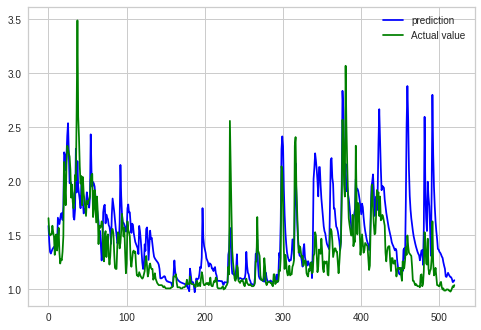

In [35]:
trainer.save_checkpoint("lstm.ckpt")
model.eval()
model.freeze()
loader = dm.test_dataloader()
print(dm.testsize)
mae = []
mse = []
predictions =[]
truth = []
for xtest, labels in iter(loader):
    y_hat = model(xtest)
    #print(labels.shape)
    #print(y_hat.shape)
    mae.append(mean_absolute_error(labels,y_hat))
    mse.append(mean_squared_error(labels,y_hat))
    predictions.append(y_hat)
    truth.append(labels)


p=np.concatenate(predictions)
y=np.concatenate(truth)
print("mae =",mean_absolute_error(y,p))
print("mse =",mean_squared_error(y,p))

plt.plot(p,color="blue",label='prediction')
plt.plot(y,color="green",label='Actual value')
plt.legend()
plt.show()

# Reuse the model on other water dataset
We can use the same LSTM model on other water dataset bying training on the Rainfall and temperature data to predict the water level or flow rate.
Here we generalize the Datamodule

In [36]:
class GeneralDataModule(pl.LightningDataModule):
    '''
    PyTorch Lighting DataModule subclass:
    https://pytorch-lightning.readthedocs.io/en/latest/datamodules.html

    Serves the purpose of aggregating all data loading
      and processing work in one place.
    '''

    def __init__(self,file,target, seq_len=1, batch_size=128, num_workers=0):
        super().__init__()
        self.seq_len = seq_len
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.X_train = None
        self.y_train = None
        self.X_val = None
        self.y_val = None
        self.X_test = None
        self.X_test = None
        self.columns = None
        self.preprocessing = None
        self.testsize = 0
        self.file = file
        self.target = target

    def prepare_data(self):
        pass

    def setup(self, stage=None):

        if stage == 'fit' and self.X_train is not None:
            return
        if stage == 'test' and self.X_test is not None:
            return
        if stage is None and self.X_train is not None and self.X_test is not None:
            return


        data = pd.read_csv(self.file)
        df = data.dropna().reset_index()
        df['date'] = df['Date'].apply(lambda x: datetime.strptime(x, "%d/%m/%Y"))
        y = df.iloc[0]['date'].year
        df['year-month'] = df['date'].apply(lambda x: int((x.year-y)*12+x.month))
        df['year'] = df['date'].apply(lambda x: int(x.year))
        df['month'] = df['date'].apply(lambda x: int(x.month))
        df['day'] = df['date'].apply(lambda x: int(x.day))

        X = df[[ f for f in df.columns if f.startswith('Rain') or f.startswith('Temperature')]]
        if len(X.columns) >= 2:
            X_reduced = PCA(n_components=2).fit_transform(X)
            pf = pd.DataFrame(X_reduced, columns=['PCA1','PCA2'])
            df['PCA1'] = pf['PCA1']
            df['PCA2'] = pf['PCA2']
            df['PCA11'] = pf['PCA1']*pf['PCA1']
            df['PCA22'] = pf['PCA2']*pf['PCA2']
            df['PCA12'] = pf['PCA1']*pf['PCA2']

            features = ['PCA1','PCA2','PCA11','PCA22','PCA12','month']
        else:
            print("single feature")
            features = list(X.columns.values)
            print(features)
            features.append("month")
            print(features)
        tgt = self.target
        label = [tgt]
        print("columns")
        print(features + label)
        y0 = int(df.iloc[0]['date'].year)
        print(y0)
        y1 = int(df.iloc[-1]['date'].year)
        print(y1)
        print(y1-y0)
        t=(y1-y0)/2
        print(t)
        T = int(len(df)*0.7)
        df = df.ffill().bfill()
        xtrain = df.iloc[:T][features + label]
        xtest = df.iloc[T:][features + label]
        print(x_train.size,x_test.size)

        features = xtrain.columns[:-1]
        label = xtrain.columns[-1]
        X_train = xtrain.iloc[:-50]
        X_val = xtrain.iloc[-50:]

        if stage == 'fit' or stage is None:
            self.X_train = X_train[features].values
            self.y_train = X_train[label].values.reshape((-1, 1))
            self.X_val = X_val[features].values
            self.y_val = X_val[label].values.reshape((-1, 1))

        if stage == 'test' or stage is None:
            self.X_test = xtest[features].values
            self.y_test = xtest[label].values.reshape((-1, 1))

    def train_dataloader(self):
        train_dataset = TimeseriesDataset(self.X_train,
                                          self.y_train,
                                          seq_len=self.seq_len)
        train_loader = DataLoader(train_dataset,
                                  batch_size=self.batch_size,
                                  shuffle=False,
                                  num_workers=self.num_workers)

        return train_loader

    def val_dataloader(self):
        val_dataset = TimeseriesDataset(self.X_val,
                                        self.y_val,
                                        seq_len=self.seq_len)
        val_loader = DataLoader(val_dataset,
                                batch_size=self.batch_size,
                                shuffle=False,
                                num_workers=self.num_workers)

        return val_loader

    def test_dataloader(self):
        test_dataset = TimeseriesDataset(self.X_test,
                                         self.y_test,
                                         seq_len=self.seq_len)
        self.testsize = len(test_dataset)
        test_loader = DataLoader(test_dataset,
                                 batch_size=self.batch_size,
                                 shuffle=False,
                                 num_workers=self.num_workers)

        return test_loader

In [37]:

finalresult = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if "csv" in filename:
            csvfile = os.path.join(dirname, filename)
            print(csvfile)
            df1 = pd.read_csv(csvfile)
            features = [ f for f in df1.columns if f.startswith('Rain') or f.startswith('Temperature')]
            print(features)
            if len(features) < 2:
                print(csvfile,"single feature")
                p = dict(
                    seq_len = 28,
                    batch_size = 60,
                    criterion = nn.MSELoss(),
                    max_epochs = 100,
                    n_features = 2,
                    hidden_size = 100,
                    num_layers = 2,
                    dropout = 0.2,
                    learning_rate = 0.001,
                )
            else:
                p = dict(
                    seq_len = 28,
                    batch_size = 60,
                    criterion = nn.MSELoss(),
                    max_epochs = 100,
                    n_features = 6,
                    hidden_size = 100,
                    num_layers = 2,
                    dropout = 0.2,
                    learning_rate = 0.001,
                )
            model = LSTMRegressor(
                n_features = p['n_features'],
                hidden_size = p['hidden_size'],
                seq_len = p['seq_len'],
                batch_size = p['batch_size'],
                criterion = p['criterion'],
                num_layers = p['num_layers'],
                dropout = p['dropout'],
                learning_rate = p['learning_rate']
            )
            targets = [ f for f in df1.columns if f.startswith('Depth_to_Groundwater') or f.startswith('Volume') or f.startswith('Hydrometry') or f.startswith('Flow_Rate')]
            for tgt in targets:
                print(csvfile,tgt)
                gdm = GeneralDataModule(
                    file = csvfile,
                    target = tgt,
                    seq_len = p['seq_len'],
                    batch_size = p['batch_size']
                )
                trainer.fit(model, gdm)
                testresult = trainer.test(model, datamodule=gdm)
                print(testresult)
                finalresult.append({"file": filename, "target": tgt, "loss": testresult[0]["test_loss"]})


  | Name      | Type    | Params
--------------------------------------
0 | criterion | MSELoss | 0     
1 | lstm      | LSTM    | 124 K 
2 | linear    | Linear  | 101   


/kaggle/input/acea-water-prediction/Aquifer_Doganella.csv
['Rainfall_Monteporzio', 'Rainfall_Velletri', 'Temperature_Monteporzio', 'Temperature_Velletri']
/kaggle/input/acea-water-prediction/Aquifer_Doganella.csv Depth_to_Groundwater_Pozzo_1
columns
['PCA1', 'PCA2', 'PCA11', 'PCA22', 'PCA12', 'month', 'Depth_to_Groundwater_Pozzo_1']
2019
2020
1
0.5
12 4376



  | Name      | Type    | Params
--------------------------------------
0 | criterion | MSELoss | 0     
1 | lstm      | LSTM    | 124 K 
2 | linear    | Linear  | 101   


columns
['PCA1', 'PCA2', 'PCA11', 'PCA22', 'PCA12', 'month', 'Depth_to_Groundwater_Pozzo_1']
2019
2020
1
0.5
12 4376
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': tensor(2437.5493),
 'train_loss': tensor(1794.3007),
 'val_loss': tensor(2610.7671)}
--------------------------------------------------------------------------------
[{'train_loss': 1794.3006591796875, 'val_loss': 2610.76708984375, 'test_loss': 2437.54931640625}]
/kaggle/input/acea-water-prediction/Aquifer_Doganella.csv Depth_to_Groundwater_Pozzo_2
columns
['PCA1', 'PCA2', 'PCA11', 'PCA22', 'PCA12', 'month', 'Depth_to_Groundwater_Pozzo_2']
2019
2020
1
0.5
12 4376



  | Name      | Type    | Params
--------------------------------------
0 | criterion | MSELoss | 0     
1 | lstm      | LSTM    | 124 K 
2 | linear    | Linear  | 101   


columns
['PCA1', 'PCA2', 'PCA11', 'PCA22', 'PCA12', 'month', 'Depth_to_Groundwater_Pozzo_2']
2019
2020
1
0.5
12 4376
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': tensor(10023.1064),
 'train_loss': tensor(10159.1123),
 'val_loss': tensor(10194.3672)}
--------------------------------------------------------------------------------
[{'train_loss': 10159.1123046875, 'val_loss': 10194.3671875, 'test_loss': 10023.1064453125}]
/kaggle/input/acea-water-prediction/Aquifer_Doganella.csv Depth_to_Groundwater_Pozzo_3
columns
['PCA1', 'PCA2', 'PCA11', 'PCA22', 'PCA12', 'month', 'Depth_to_Groundwater_Pozzo_3']
2019
2020
1
0.5
12 4376



  | Name      | Type    | Params
--------------------------------------
0 | criterion | MSELoss | 0     
1 | lstm      | LSTM    | 124 K 
2 | linear    | Linear  | 101   


columns
['PCA1', 'PCA2', 'PCA11', 'PCA22', 'PCA12', 'month', 'Depth_to_Groundwater_Pozzo_3']
2019
2020
1
0.5
12 4376
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': tensor(10751.1670),
 'train_loss': tensor(12548.7549),
 'val_loss': tensor(12374.2559)}
--------------------------------------------------------------------------------
[{'train_loss': 12548.7548828125, 'val_loss': 12374.255859375, 'test_loss': 10751.1669921875}]
/kaggle/input/acea-water-prediction/Aquifer_Doganella.csv Depth_to_Groundwater_Pozzo_4
columns
['PCA1', 'PCA2', 'PCA11', 'PCA22', 'PCA12', 'month', 'Depth_to_Groundwater_Pozzo_4']
2019
2020
1
0.5
12 4376



  | Name      | Type    | Params
--------------------------------------
0 | criterion | MSELoss | 0     
1 | lstm      | LSTM    | 124 K 
2 | linear    | Linear  | 101   


columns
['PCA1', 'PCA2', 'PCA11', 'PCA22', 'PCA12', 'month', 'Depth_to_Groundwater_Pozzo_4']
2019
2020
1
0.5
12 4376
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': tensor(10256.9092),
 'train_loss': tensor(10298.8740),
 'val_loss': tensor(10393.5322)}
--------------------------------------------------------------------------------
[{'train_loss': 10298.8740234375, 'val_loss': 10393.5322265625, 'test_loss': 10256.9091796875}]
/kaggle/input/acea-water-prediction/Aquifer_Doganella.csv Depth_to_Groundwater_Pozzo_5
columns
['PCA1', 'PCA2', 'PCA11', 'PCA22', 'PCA12', 'month', 'Depth_to_Groundwater_Pozzo_5']
2019
2020
1
0.5
12 4376



  | Name      | Type    | Params
--------------------------------------
0 | criterion | MSELoss | 0     
1 | lstm      | LSTM    | 124 K 
2 | linear    | Linear  | 101   


columns
['PCA1', 'PCA2', 'PCA11', 'PCA22', 'PCA12', 'month', 'Depth_to_Groundwater_Pozzo_5']
2019
2020
1
0.5
12 4376
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': tensor(10752.1836),
 'train_loss': tensor(10737.2949),
 'val_loss': tensor(10777.4277)}
--------------------------------------------------------------------------------
[{'train_loss': 10737.294921875, 'val_loss': 10777.427734375, 'test_loss': 10752.18359375}]
/kaggle/input/acea-water-prediction/Aquifer_Doganella.csv Depth_to_Groundwater_Pozzo_6
columns
['PCA1', 'PCA2', 'PCA11', 'PCA22', 'PCA12', 'month', 'Depth_to_Groundwater_Pozzo_6']
2019
2020
1
0.5
12 4376



  | Name      | Type    | Params
--------------------------------------
0 | criterion | MSELoss | 0     
1 | lstm      | LSTM    | 124 K 
2 | linear    | Linear  | 101   


columns
['PCA1', 'PCA2', 'PCA11', 'PCA22', 'PCA12', 'month', 'Depth_to_Groundwater_Pozzo_6']
2019
2020
1
0.5
12 4376
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': tensor(9498.3818),
 'train_loss': tensor(8824.6865),
 'val_loss': tensor(8681.3291)}
--------------------------------------------------------------------------------
[{'train_loss': 8824.6865234375, 'val_loss': 8681.3291015625, 'test_loss': 9498.3818359375}]
/kaggle/input/acea-water-prediction/Aquifer_Doganella.csv Depth_to_Groundwater_Pozzo_7
columns
['PCA1', 'PCA2', 'PCA11', 'PCA22', 'PCA12', 'month', 'Depth_to_Groundwater_Pozzo_7']
2019
2020
1
0.5
12 4376



  | Name      | Type    | Params
--------------------------------------
0 | criterion | MSELoss | 0     
1 | lstm      | LSTM    | 124 K 
2 | linear    | Linear  | 101   


columns
['PCA1', 'PCA2', 'PCA11', 'PCA22', 'PCA12', 'month', 'Depth_to_Groundwater_Pozzo_7']
2019
2020
1
0.5
12 4376
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': tensor(9073.0322),
 'train_loss': tensor(9157.0908),
 'val_loss': tensor(9260.3779)}
--------------------------------------------------------------------------------
[{'train_loss': 9157.0908203125, 'val_loss': 9260.3779296875, 'test_loss': 9073.0322265625}]
/kaggle/input/acea-water-prediction/Aquifer_Doganella.csv Depth_to_Groundwater_Pozzo_8
columns
['PCA1', 'PCA2', 'PCA11', 'PCA22', 'PCA12', 'month', 'Depth_to_Groundwater_Pozzo_8']
2019
2020
1
0.5
12 4376



  | Name      | Type    | Params
--------------------------------------
0 | criterion | MSELoss | 0     
1 | lstm      | LSTM    | 124 K 
2 | linear    | Linear  | 101   


columns
['PCA1', 'PCA2', 'PCA11', 'PCA22', 'PCA12', 'month', 'Depth_to_Groundwater_Pozzo_8']
2019
2020
1
0.5
12 4376
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': tensor(9247.4072),
 'train_loss': tensor(9385.9219),
 'val_loss': tensor(9678.4209)}
--------------------------------------------------------------------------------
[{'train_loss': 9385.921875, 'val_loss': 9678.4208984375, 'test_loss': 9247.4072265625}]
/kaggle/input/acea-water-prediction/Aquifer_Doganella.csv Depth_to_Groundwater_Pozzo_9
columns
['PCA1', 'PCA2', 'PCA11', 'PCA22', 'PCA12', 'month', 'Depth_to_Groundwater_Pozzo_9']
2019
2020
1
0.5
12 4376



  | Name      | Type    | Params
--------------------------------------
0 | criterion | MSELoss | 0     
1 | lstm      | LSTM    | 124 K 
2 | linear    | Linear  | 101   


columns
['PCA1', 'PCA2', 'PCA11', 'PCA22', 'PCA12', 'month', 'Depth_to_Groundwater_Pozzo_9']
2019
2020
1
0.5
12 4376
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': tensor(7847.2939),
 'train_loss': tensor(8080.8188),
 'val_loss': tensor(8177.4448)}
--------------------------------------------------------------------------------
[{'train_loss': 8080.81884765625, 'val_loss': 8177.44482421875, 'test_loss': 7847.2939453125}]
/kaggle/input/acea-water-prediction/Aquifer_Doganella.csv Volume_Pozzo_1
columns
['PCA1', 'PCA2', 'PCA11', 'PCA22', 'PCA12', 'month', 'Volume_Pozzo_1']
2019
2020
1
0.5
12 4376



  | Name      | Type    | Params
--------------------------------------
0 | criterion | MSELoss | 0     
1 | lstm      | LSTM    | 124 K 
2 | linear    | Linear  | 101   


columns
['PCA1', 'PCA2', 'PCA11', 'PCA22', 'PCA12', 'month', 'Volume_Pozzo_1']
2019
2020
1
0.5
12 4376
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': tensor(3223320.7500),
 'train_loss': tensor(9656685.),
 'val_loss': tensor(3211366.2500)}
--------------------------------------------------------------------------------
[{'train_loss': 9656685.0, 'val_loss': 3211366.25, 'test_loss': 3223320.75}]
/kaggle/input/acea-water-prediction/Aquifer_Doganella.csv Volume_Pozzo_2
columns
['PCA1', 'PCA2', 'PCA11', 'PCA22', 'PCA12', 'month', 'Volume_Pozzo_2']
2019
2020
1
0.5
12 4376



  | Name      | Type    | Params
--------------------------------------
0 | criterion | MSELoss | 0     
1 | lstm      | LSTM    | 124 K 
2 | linear    | Linear  | 101   


columns
['PCA1', 'PCA2', 'PCA11', 'PCA22', 'PCA12', 'month', 'Volume_Pozzo_2']
2019
2020
1
0.5
12 4376
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': tensor(14567617.),
 'train_loss': tensor(14656481.),
 'val_loss': tensor(15036735.)}
--------------------------------------------------------------------------------
[{'train_loss': 14656481.0, 'val_loss': 15036735.0, 'test_loss': 14567617.0}]
/kaggle/input/acea-water-prediction/Aquifer_Doganella.csv Volume_Pozzo_3
columns
['PCA1', 'PCA2', 'PCA11', 'PCA22', 'PCA12', 'month', 'Volume_Pozzo_3']
2019
2020
1
0.5
12 4376



  | Name      | Type    | Params
--------------------------------------
0 | criterion | MSELoss | 0     
1 | lstm      | LSTM    | 124 K 
2 | linear    | Linear  | 101   


columns
['PCA1', 'PCA2', 'PCA11', 'PCA22', 'PCA12', 'month', 'Volume_Pozzo_3']
2019
2020
1
0.5
12 4376
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': tensor(6386364.),
 'train_loss': tensor(8201713.),
 'val_loss': tensor(8646255.)}
--------------------------------------------------------------------------------
[{'train_loss': 8201713.0, 'val_loss': 8646255.0, 'test_loss': 6386364.0}]
/kaggle/input/acea-water-prediction/Aquifer_Doganella.csv Volume_Pozzo_4
columns
['PCA1', 'PCA2', 'PCA11', 'PCA22', 'PCA12', 'month', 'Volume_Pozzo_4']
2019
2020
1
0.5
12 4376



  | Name      | Type    | Params
--------------------------------------
0 | criterion | MSELoss | 0     
1 | lstm      | LSTM    | 124 K 
2 | linear    | Linear  | 101   


columns
['PCA1', 'PCA2', 'PCA11', 'PCA22', 'PCA12', 'month', 'Volume_Pozzo_4']
2019
2020
1
0.5
12 4376
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': tensor(14618371.),
 'train_loss': tensor(14328886.),
 'val_loss': tensor(14996437.)}
--------------------------------------------------------------------------------
[{'train_loss': 14328886.0, 'val_loss': 14996437.0, 'test_loss': 14618371.0}]
/kaggle/input/acea-water-prediction/Aquifer_Doganella.csv Volume_Pozzo_5+6
columns
['PCA1', 'PCA2', 'PCA11', 'PCA22', 'PCA12', 'month', 'Volume_Pozzo_5+6']
2019
2020
1
0.5
12 4376



  | Name      | Type    | Params
--------------------------------------
0 | criterion | MSELoss | 0     
1 | lstm      | LSTM    | 124 K 
2 | linear    | Linear  | 101   


columns
['PCA1', 'PCA2', 'PCA11', 'PCA22', 'PCA12', 'month', 'Volume_Pozzo_5+6']
2019
2020
1
0.5
12 4376
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': tensor(56127964.),
 'train_loss': tensor(60107084.),
 'val_loss': tensor(63248792.)}
--------------------------------------------------------------------------------
[{'train_loss': 60107084.0, 'val_loss': 63248792.0, 'test_loss': 56127964.0}]
/kaggle/input/acea-water-prediction/Aquifer_Doganella.csv Volume_Pozzo_7
columns
['PCA1', 'PCA2', 'PCA11', 'PCA22', 'PCA12', 'month', 'Volume_Pozzo_7']
2019
2020
1
0.5
12 4376



  | Name      | Type    | Params
--------------------------------------
0 | criterion | MSELoss | 0     
1 | lstm      | LSTM    | 124 K 
2 | linear    | Linear  | 101   


columns
['PCA1', 'PCA2', 'PCA11', 'PCA22', 'PCA12', 'month', 'Volume_Pozzo_7']
2019
2020
1
0.5
12 4376
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': tensor(6413062.),
 'train_loss': tensor(4997951.),
 'val_loss': tensor(8266745.5000)}
--------------------------------------------------------------------------------
[{'train_loss': 4997951.0, 'val_loss': 8266745.5, 'test_loss': 6413062.0}]
/kaggle/input/acea-water-prediction/Aquifer_Doganella.csv Volume_Pozzo_8
columns
['PCA1', 'PCA2', 'PCA11', 'PCA22', 'PCA12', 'month', 'Volume_Pozzo_8']
2019
2020
1
0.5
12 4376



  | Name      | Type    | Params
--------------------------------------
0 | criterion | MSELoss | 0     
1 | lstm      | LSTM    | 124 K 
2 | linear    | Linear  | 101   


columns
['PCA1', 'PCA2', 'PCA11', 'PCA22', 'PCA12', 'month', 'Volume_Pozzo_8']
2019
2020
1
0.5
12 4376
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': tensor(15068427.),
 'train_loss': tensor(14753106.),
 'val_loss': tensor(15114861.)}
--------------------------------------------------------------------------------
[{'train_loss': 14753106.0, 'val_loss': 15114861.0, 'test_loss': 15068427.0}]
/kaggle/input/acea-water-prediction/Aquifer_Doganella.csv Volume_Pozzo_9
columns
['PCA1', 'PCA2', 'PCA11', 'PCA22', 'PCA12', 'month', 'Volume_Pozzo_9']
2019
2020
1
0.5
12 4376
columns
['PCA1', 'PCA2', 'PCA11', 'PCA22', 'PCA12', 'month', 'Volume_Pozzo_9']
2019
2020
1
0.5
12 4376
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': tensor(10882775.),
 'train_loss': tensor(9988150.),
 'val_loss': tensor(10898075.)}
------------------------------------------------


  | Name      | Type    | Params
--------------------------------------
0 | criterion | MSELoss | 0     
1 | lstm      | LSTM    | 124 K 
2 | linear    | Linear  | 101   


columns
['PCA1', 'PCA2', 'PCA11', 'PCA22', 'PCA12', 'month', 'Depth_to_Groundwater_LT2']
2011
2020
9
4.5
12 4376
columns
['PCA1', 'PCA2', 'PCA11', 'PCA22', 'PCA12', 'month', 'Depth_to_Groundwater_LT2']
2011
2020
9
4.5
12 4376



  | Name      | Type    | Params
--------------------------------------
0 | criterion | MSELoss | 0     
1 | lstm      | LSTM    | 124 K 
2 | linear    | Linear  | 101   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': tensor(70.3283),
 'train_loss': tensor(70.9659),
 'val_loss': tensor(63.8147)}
--------------------------------------------------------------------------------
[{'train_loss': 70.96590423583984, 'val_loss': 63.814666748046875, 'test_loss': 70.32830810546875}]
/kaggle/input/acea-water-prediction/Aquifer_Auser.csv Depth_to_Groundwater_SAL
columns
['PCA1', 'PCA2', 'PCA11', 'PCA22', 'PCA12', 'month', 'Depth_to_Groundwater_SAL']
2011
2020
9
4.5
12 4376
columns
['PCA1', 'PCA2', 'PCA11', 'PCA22', 'PCA12', 'month', 'Depth_to_Groundwater_SAL']
2011
2020
9
4.5
12 4376



  | Name      | Type    | Params
--------------------------------------
0 | criterion | MSELoss | 0     
1 | lstm      | LSTM    | 124 K 
2 | linear    | Linear  | 101   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': tensor(0.8157),
 'train_loss': tensor(3.0389),
 'val_loss': tensor(0.6432)}
--------------------------------------------------------------------------------
[{'train_loss': 3.0389206409454346, 'val_loss': 0.6432015299797058, 'test_loss': 0.8156736493110657}]
/kaggle/input/acea-water-prediction/Aquifer_Auser.csv Depth_to_Groundwater_PAG
columns
['PCA1', 'PCA2', 'PCA11', 'PCA22', 'PCA12', 'month', 'Depth_to_Groundwater_PAG']
2011
2020
9
4.5
12 4376
columns
['PCA1', 'PCA2', 'PCA11', 'PCA22', 'PCA12', 'month', 'Depth_to_Groundwater_PAG']
2011
2020
9
4.5
12 4376



  | Name      | Type    | Params
--------------------------------------
0 | criterion | MSELoss | 0     
1 | lstm      | LSTM    | 124 K 
2 | linear    | Linear  | 101   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': tensor(0.4122),
 'train_loss': tensor(1.3181),
 'val_loss': tensor(0.0340)}
--------------------------------------------------------------------------------
[{'train_loss': 1.3181451559066772, 'val_loss': 0.03400483727455139, 'test_loss': 0.4121851325035095}]
/kaggle/input/acea-water-prediction/Aquifer_Auser.csv Depth_to_Groundwater_CoS
columns
['PCA1', 'PCA2', 'PCA11', 'PCA22', 'PCA12', 'month', 'Depth_to_Groundwater_CoS']
2011
2020
9
4.5
12 4376
columns
['PCA1', 'PCA2', 'PCA11', 'PCA22', 'PCA12', 'month', 'Depth_to_Groundwater_CoS']
2011
2020
9
4.5
12 4376



  | Name      | Type    | Params
--------------------------------------
0 | criterion | MSELoss | 0     
1 | lstm      | LSTM    | 124 K 
2 | linear    | Linear  | 101   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': tensor(1.3947),
 'train_loss': tensor(3.1141),
 'val_loss': tensor(1.6375)}
--------------------------------------------------------------------------------
[{'train_loss': 3.1141412258148193, 'val_loss': 1.6374651193618774, 'test_loss': 1.394668459892273}]
/kaggle/input/acea-water-prediction/Aquifer_Auser.csv Depth_to_Groundwater_DIEC
columns
['PCA1', 'PCA2', 'PCA11', 'PCA22', 'PCA12', 'month', 'Depth_to_Groundwater_DIEC']
2011
2020
9
4.5
12 4376
columns
['PCA1', 'PCA2', 'PCA11', 'PCA22', 'PCA12', 'month', 'Depth_to_Groundwater_DIEC']
2011
2020
9
4.5
12 4376



  | Name      | Type    | Params
--------------------------------------
0 | criterion | MSELoss | 0     
1 | lstm      | LSTM    | 124 K 
2 | linear    | Linear  | 101   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': tensor(0.4023),
 'train_loss': tensor(4.0859),
 'val_loss': tensor(0.3307)}
--------------------------------------------------------------------------------
[{'train_loss': 4.085860252380371, 'val_loss': 0.330669105052948, 'test_loss': 0.40232810378074646}]
/kaggle/input/acea-water-prediction/Aquifer_Auser.csv Volume_POL
columns
['PCA1', 'PCA2', 'PCA11', 'PCA22', 'PCA12', 'month', 'Volume_POL']
2011
2020
9
4.5
12 4376
columns
['PCA1', 'PCA2', 'PCA11', 'PCA22', 'PCA12', 'month', 'Volume_POL']
2011
2020
9
4.5
12 4376



  | Name      | Type    | Params
--------------------------------------
0 | criterion | MSELoss | 0     
1 | lstm      | LSTM    | 124 K 
2 | linear    | Linear  | 101   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': tensor(46966884.),
 'train_loss': tensor(33011472.),
 'val_loss': tensor(33238462.)}
--------------------------------------------------------------------------------
[{'train_loss': 33011472.0, 'val_loss': 33238462.0, 'test_loss': 46966884.0}]
/kaggle/input/acea-water-prediction/Aquifer_Auser.csv Volume_CC1
columns
['PCA1', 'PCA2', 'PCA11', 'PCA22', 'PCA12', 'month', 'Volume_CC1']
2011
2020
9
4.5
12 4376
columns
['PCA1', 'PCA2', 'PCA11', 'PCA22', 'PCA12', 'month', 'Volume_CC1']
2011
2020
9
4.5
12 4376



  | Name      | Type    | Params
--------------------------------------
0 | criterion | MSELoss | 0     
1 | lstm      | LSTM    | 124 K 
2 | linear    | Linear  | 101   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': tensor(2.3185e+08),
 'train_loss': tensor(3.0084e+08),
 'val_loss': tensor(2.7748e+08)}
--------------------------------------------------------------------------------
[{'train_loss': 300837792.0, 'val_loss': 277484448.0, 'test_loss': 231852368.0}]
/kaggle/input/acea-water-prediction/Aquifer_Auser.csv Volume_CC2
columns
['PCA1', 'PCA2', 'PCA11', 'PCA22', 'PCA12', 'month', 'Volume_CC2']
2011
2020
9
4.5
12 4376
columns
['PCA1', 'PCA2', 'PCA11', 'PCA22', 'PCA12', 'month', 'Volume_CC2']
2011
2020
9
4.5
12 4376



  | Name      | Type    | Params
--------------------------------------
0 | criterion | MSELoss | 0     
1 | lstm      | LSTM    | 124 K 
2 | linear    | Linear  | 101   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': tensor(1.0003e+08),
 'train_loss': tensor(1.1325e+08),
 'val_loss': tensor(1.1718e+08)}
--------------------------------------------------------------------------------
[{'train_loss': 113253128.0, 'val_loss': 117180952.0, 'test_loss': 100030352.0}]
/kaggle/input/acea-water-prediction/Aquifer_Auser.csv Volume_CSA
columns
['PCA1', 'PCA2', 'PCA11', 'PCA22', 'PCA12', 'month', 'Volume_CSA']
2011
2020
9
4.5
12 4376
columns
['PCA1', 'PCA2', 'PCA11', 'PCA22', 'PCA12', 'month', 'Volume_CSA']
2011
2020
9
4.5
12 4376



  | Name      | Type    | Params
--------------------------------------
0 | criterion | MSELoss | 0     
1 | lstm      | LSTM    | 124 K 
2 | linear    | Linear  | 101   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': tensor(39690196.),
 'train_loss': tensor(31324950.),
 'val_loss': tensor(30990338.)}
--------------------------------------------------------------------------------
[{'train_loss': 31324950.0, 'val_loss': 30990338.0, 'test_loss': 39690196.0}]
/kaggle/input/acea-water-prediction/Aquifer_Auser.csv Volume_CSAL
columns
['PCA1', 'PCA2', 'PCA11', 'PCA22', 'PCA12', 'month', 'Volume_CSAL']
2011
2020
9
4.5
12 4376
columns
['PCA1', 'PCA2', 'PCA11', 'PCA22', 'PCA12', 'month', 'Volume_CSAL']
2011
2020
9
4.5
12 4376



  | Name      | Type    | Params
--------------------------------------
0 | criterion | MSELoss | 0     
1 | lstm      | LSTM    | 124 K 
2 | linear    | Linear  | 101   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': tensor(12897000.),
 'train_loss': tensor(18911942.),
 'val_loss': tensor(19174578.)}
--------------------------------------------------------------------------------
[{'train_loss': 18911942.0, 'val_loss': 19174578.0, 'test_loss': 12897000.0}]
/kaggle/input/acea-water-prediction/Aquifer_Auser.csv Hydrometry_Monte_S_Quirico
columns
['PCA1', 'PCA2', 'PCA11', 'PCA22', 'PCA12', 'month', 'Hydrometry_Monte_S_Quirico']
2011
2020
9
4.5
12 4376
columns
['PCA1', 'PCA2', 'PCA11', 'PCA22', 'PCA12', 'month', 'Hydrometry_Monte_S_Quirico']
2011
2020
9
4.5
12 4376



  | Name      | Type    | Params
--------------------------------------
0 | criterion | MSELoss | 0     
1 | lstm      | LSTM    | 124 K 
2 | linear    | Linear  | 101   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': tensor(138.9424),
 'train_loss': tensor(160.1723),
 'val_loss': tensor(142.0062)}
--------------------------------------------------------------------------------
[{'train_loss': 160.17225646972656, 'val_loss': 142.00619506835938, 'test_loss': 138.9424285888672}]
/kaggle/input/acea-water-prediction/Aquifer_Auser.csv Hydrometry_Piaggione
columns
['PCA1', 'PCA2', 'PCA11', 'PCA22', 'PCA12', 'month', 'Hydrometry_Piaggione']
2011
2020
9
4.5
12 4376
columns
['PCA1', 'PCA2', 'PCA11', 'PCA22', 'PCA12', 'month', 'Hydrometry_Piaggione']
2011
2020
9
4.5
12 4376



  | Name      | Type    | Params
--------------------------------------
0 | criterion | MSELoss | 0     
1 | lstm      | LSTM    | 124 K 
2 | linear    | Linear  | 101   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': tensor(62.1803),
 'train_loss': tensor(101.4117),
 'val_loss': tensor(62.5997)}
--------------------------------------------------------------------------------
[{'train_loss': 101.4117431640625, 'val_loss': 62.59965133666992, 'test_loss': 62.180274963378906}]
/kaggle/input/acea-water-prediction/Water_Spring_Amiata.csv
['Rainfall_Castel_del_Piano', 'Rainfall_Abbadia_S_Salvatore', 'Rainfall_S_Fiora', 'Rainfall_Laghetto_Verde', 'Rainfall_Vetta_Amiata', 'Temperature_Abbadia_S_Salvatore', 'Temperature_S_Fiora', 'Temperature_Laghetto_Verde']
/kaggle/input/acea-water-prediction/Water_Spring_Amiata.csv Depth_to_Groundwater_S_Fiora_8
columns
['PCA1', 'PCA2', 'PCA11', 'PCA22', 'PCA12', 'month', 'Depth_to_Groundwater_S_Fiora_8']
2016
2020
4
2.0
12 4376
columns
['PCA1', 'PCA2', 'PCA11', 'PCA22', 'PCA12', 'month', 'Depth_to_Groundwater_S_Fiora_8']
2016
2020
4
2.0
12 4376
-------


  | Name      | Type    | Params
--------------------------------------
0 | criterion | MSELoss | 0     
1 | lstm      | LSTM    | 124 K 
2 | linear    | Linear  | 101   


columns
['PCA1', 'PCA2', 'PCA11', 'PCA22', 'PCA12', 'month', 'Depth_to_Groundwater_S_Fiora_11bis']
2016
2020
4
2.0
12 4376
columns
['PCA1', 'PCA2', 'PCA11', 'PCA22', 'PCA12', 'month', 'Depth_to_Groundwater_S_Fiora_11bis']
2016
2020
4
2.0
12 4376
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': tensor(2278.5244),
 'train_loss': tensor(2351.5630),
 'val_loss': tensor(2324.4080)}
--------------------------------------------------------------------------------
[{'train_loss': 2351.56298828125, 'val_loss': 2324.407958984375, 'test_loss': 2278.5244140625}]
/kaggle/input/acea-water-prediction/Water_Spring_Amiata.csv Depth_to_Groundwater_David_Lazzaretti



  | Name      | Type    | Params
--------------------------------------
0 | criterion | MSELoss | 0     
1 | lstm      | LSTM    | 124 K 
2 | linear    | Linear  | 101   


columns
['PCA1', 'PCA2', 'PCA11', 'PCA22', 'PCA12', 'month', 'Depth_to_Groundwater_David_Lazzaretti']
2016
2020
4
2.0
12 4376
columns
['PCA1', 'PCA2', 'PCA11', 'PCA22', 'PCA12', 'month', 'Depth_to_Groundwater_David_Lazzaretti']
2016
2020
4
2.0
12 4376
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': tensor(90244.8984),
 'train_loss': tensor(94460.5156),
 'val_loss': tensor(93923.2188)}
--------------------------------------------------------------------------------
[{'train_loss': 94460.515625, 'val_loss': 93923.21875, 'test_loss': 90244.8984375}]
/kaggle/input/acea-water-prediction/Water_Spring_Amiata.csv Flow_Rate_Bugnano



  | Name      | Type    | Params
--------------------------------------
0 | criterion | MSELoss | 0     
1 | lstm      | LSTM    | 124 K 
2 | linear    | Linear  | 101   


columns
['PCA1', 'PCA2', 'PCA11', 'PCA22', 'PCA12', 'month', 'Flow_Rate_Bugnano']
2016
2020
4
2.0
12 4376
columns
['PCA1', 'PCA2', 'PCA11', 'PCA22', 'PCA12', 'month', 'Flow_Rate_Bugnano']
2016
2020
4
2.0
12 4376
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': tensor(16.8789),
 'train_loss': tensor(19.7707),
 'val_loss': tensor(17.1402)}
--------------------------------------------------------------------------------
[{'train_loss': 19.770668029785156, 'val_loss': 17.140151977539062, 'test_loss': 16.878923416137695}]
/kaggle/input/acea-water-prediction/Water_Spring_Amiata.csv Flow_Rate_Arbure



  | Name      | Type    | Params
--------------------------------------
0 | criterion | MSELoss | 0     
1 | lstm      | LSTM    | 124 K 
2 | linear    | Linear  | 101   


columns
['PCA1', 'PCA2', 'PCA11', 'PCA22', 'PCA12', 'month', 'Flow_Rate_Arbure']
2016
2020
4
2.0
12 4376
columns
['PCA1', 'PCA2', 'PCA11', 'PCA22', 'PCA12', 'month', 'Flow_Rate_Arbure']
2016
2020
4
2.0
12 4376
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': tensor(1.5209),
 'train_loss': tensor(0.5626),
 'val_loss': tensor(0.9645)}
--------------------------------------------------------------------------------
[{'train_loss': 0.5625562071800232, 'val_loss': 0.9645114541053772, 'test_loss': 1.52093505859375}]
/kaggle/input/acea-water-prediction/Water_Spring_Amiata.csv Flow_Rate_Ermicciolo



  | Name      | Type    | Params
--------------------------------------
0 | criterion | MSELoss | 0     
1 | lstm      | LSTM    | 124 K 
2 | linear    | Linear  | 101   


columns
['PCA1', 'PCA2', 'PCA11', 'PCA22', 'PCA12', 'month', 'Flow_Rate_Ermicciolo']
2016
2020
4
2.0
12 4376
columns
['PCA1', 'PCA2', 'PCA11', 'PCA22', 'PCA12', 'month', 'Flow_Rate_Ermicciolo']
2016
2020
4
2.0
12 4376
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': tensor(3.0896),
 'train_loss': tensor(1.0227),
 'val_loss': tensor(1.1775)}
--------------------------------------------------------------------------------
[{'train_loss': 1.0226798057556152, 'val_loss': 1.1775445938110352, 'test_loss': 3.089646100997925}]
/kaggle/input/acea-water-prediction/Water_Spring_Amiata.csv Flow_Rate_Galleria_Alta



  | Name      | Type    | Params
--------------------------------------
0 | criterion | MSELoss | 0     
1 | lstm      | LSTM    | 124 K 
2 | linear    | Linear  | 101   


columns
['PCA1', 'PCA2', 'PCA11', 'PCA22', 'PCA12', 'month', 'Flow_Rate_Galleria_Alta']
2016
2020
4
2.0
12 4376
columns
['PCA1', 'PCA2', 'PCA11', 'PCA22', 'PCA12', 'month', 'Flow_Rate_Galleria_Alta']
2016
2020
4
2.0
12 4376
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': tensor(189.7317),
 'train_loss': tensor(161.5345),
 'val_loss': tensor(158.1627)}
--------------------------------------------------------------------------------
[{'train_loss': 161.53445434570312, 'val_loss': 158.16265869140625, 'test_loss': 189.731689453125}]
/kaggle/input/acea-water-prediction/Lake_Bilancino.csv
['Rainfall_S_Piero', 'Rainfall_Mangona', 'Rainfall_S_Agata', 'Rainfall_Cavallina', 'Rainfall_Le_Croci', 'Temperature_Le_Croci']
/kaggle/input/acea-water-prediction/Lake_Bilancino.csv Flow_Rate



  | Name      | Type    | Params
--------------------------------------
0 | criterion | MSELoss | 0     
1 | lstm      | LSTM    | 124 K 
2 | linear    | Linear  | 101   


columns
['PCA1', 'PCA2', 'PCA11', 'PCA22', 'PCA12', 'month', 'Flow_Rate']
2004
2020
16
8.0
12 4376
columns
['PCA1', 'PCA2', 'PCA11', 'PCA22', 'PCA12', 'month', 'Flow_Rate']
2004
2020
16
8.0
12 4376



  | Name      | Type    | Params
--------------------------------------
0 | criterion | MSELoss | 0     
1 | lstm      | LSTM    | 124 K 
2 | linear    | Linear  | 101   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': tensor(13.2405),
 'train_loss': tensor(5.4445),
 'val_loss': tensor(2.3044)}
--------------------------------------------------------------------------------
[{'train_loss': 5.444473743438721, 'val_loss': 2.304367780685425, 'test_loss': 13.240466117858887}]
/kaggle/input/acea-water-prediction/Water_Spring_Madonna_di_Canneto.csv
['Rainfall_Settefrati', 'Temperature_Settefrati']
/kaggle/input/acea-water-prediction/Water_Spring_Madonna_di_Canneto.csv Flow_Rate_Madonna_di_Canneto
columns
['PCA1', 'PCA2', 'PCA11', 'PCA22', 'PCA12', 'month', 'Flow_Rate_Madonna_di_Canneto']
2015
2018
3
1.5
12 4376
columns
['PCA1', 'PCA2', 'PCA11', 'PCA22', 'PCA12', 'month', 'Flow_Rate_Madonna_di_Canneto']
2015
2018
3
1.5
12 4376
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': tensor(75188.2969),
 'train_loss': tensor(8


  | Name      | Type    | Params
--------------------------------------
0 | criterion | MSELoss | 0     
1 | lstm      | LSTM    | 124 K 
2 | linear    | Linear  | 101   


/kaggle/input/acea-water-prediction/Aquifer_Luco.csv Depth_to_Groundwater_Podere_Casetta
columns
['PCA1', 'PCA2', 'PCA11', 'PCA22', 'PCA12', 'month', 'Depth_to_Groundwater_Podere_Casetta']
2017
2018
1
0.5
12 4376



  | Name      | Type    | Params
--------------------------------------
0 | criterion | MSELoss | 0     
1 | lstm      | LSTM    | 124 K 
2 | linear    | Linear  | 101   


columns
['PCA1', 'PCA2', 'PCA11', 'PCA22', 'PCA12', 'month', 'Depth_to_Groundwater_Podere_Casetta']
2017
2018
1
0.5
12 4376
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': tensor(51.4234),
 'train_loss': tensor(50.6769),
 'val_loss': tensor(48.6233)}
--------------------------------------------------------------------------------
[{'train_loss': 50.67690658569336, 'val_loss': 48.623313903808594, 'test_loss': 51.42343521118164}]
/kaggle/input/acea-water-prediction/Aquifer_Luco.csv Depth_to_Groundwater_Pozzo_1
columns
['PCA1', 'PCA2', 'PCA11', 'PCA22', 'PCA12', 'month', 'Depth_to_Groundwater_Pozzo_1']
2017
2018
1
0.5
12 4376



  | Name      | Type    | Params
--------------------------------------
0 | criterion | MSELoss | 0     
1 | lstm      | LSTM    | 124 K 
2 | linear    | Linear  | 101   


columns
['PCA1', 'PCA2', 'PCA11', 'PCA22', 'PCA12', 'month', 'Depth_to_Groundwater_Pozzo_1']
2017
2018
1
0.5
12 4376
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': tensor(105.8240),
 'train_loss': tensor(116.0971),
 'val_loss': tensor(114.6340)}
--------------------------------------------------------------------------------
[{'train_loss': 116.09709167480469, 'val_loss': 114.63404083251953, 'test_loss': 105.82404327392578}]
/kaggle/input/acea-water-prediction/Aquifer_Luco.csv Depth_to_Groundwater_Pozzo_3
columns
['PCA1', 'PCA2', 'PCA11', 'PCA22', 'PCA12', 'month', 'Depth_to_Groundwater_Pozzo_3']
2017
2018
1
0.5
12 4376



  | Name      | Type    | Params
--------------------------------------
0 | criterion | MSELoss | 0     
1 | lstm      | LSTM    | 124 K 
2 | linear    | Linear  | 101   


columns
['PCA1', 'PCA2', 'PCA11', 'PCA22', 'PCA12', 'month', 'Depth_to_Groundwater_Pozzo_3']
2017
2018
1
0.5
12 4376
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': tensor(64.1114),
 'train_loss': tensor(70.5250),
 'val_loss': tensor(69.7540)}
--------------------------------------------------------------------------------
[{'train_loss': 70.52496337890625, 'val_loss': 69.75395965576172, 'test_loss': 64.11136627197266}]
/kaggle/input/acea-water-prediction/Aquifer_Luco.csv Depth_to_Groundwater_Pozzo_4
columns
['PCA1', 'PCA2', 'PCA11', 'PCA22', 'PCA12', 'month', 'Depth_to_Groundwater_Pozzo_4']
2017
2018
1
0.5
12 4376



  | Name      | Type    | Params
--------------------------------------
0 | criterion | MSELoss | 0     
1 | lstm      | LSTM    | 124 K 
2 | linear    | Linear  | 101   


columns
['PCA1', 'PCA2', 'PCA11', 'PCA22', 'PCA12', 'month', 'Depth_to_Groundwater_Pozzo_4']
2017
2018
1
0.5
12 4376
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': tensor(87.2659),
 'train_loss': tensor(186.5307),
 'val_loss': tensor(99.9570)}
--------------------------------------------------------------------------------
[{'train_loss': 186.53074645996094, 'val_loss': 99.95703125, 'test_loss': 87.26588439941406}]
/kaggle/input/acea-water-prediction/Aquifer_Luco.csv Volume_Pozzo_1
columns
['PCA1', 'PCA2', 'PCA11', 'PCA22', 'PCA12', 'month', 'Volume_Pozzo_1']
2017
2018
1
0.5
12 4376



  | Name      | Type    | Params
--------------------------------------
0 | criterion | MSELoss | 0     
1 | lstm      | LSTM    | 124 K 
2 | linear    | Linear  | 101   


columns
['PCA1', 'PCA2', 'PCA11', 'PCA22', 'PCA12', 'month', 'Volume_Pozzo_1']
2017
2018
1
0.5
12 4376
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': tensor(28359.8223),
 'train_loss': tensor(43152.3086),
 'val_loss': tensor(36384.1367)}
--------------------------------------------------------------------------------
[{'train_loss': 43152.30859375, 'val_loss': 36384.13671875, 'test_loss': 28359.822265625}]
/kaggle/input/acea-water-prediction/Aquifer_Luco.csv Volume_Pozzo_3
columns
['PCA1', 'PCA2', 'PCA11', 'PCA22', 'PCA12', 'month', 'Volume_Pozzo_3']
2017
2018
1
0.5
12 4376



  | Name      | Type    | Params
--------------------------------------
0 | criterion | MSELoss | 0     
1 | lstm      | LSTM    | 124 K 
2 | linear    | Linear  | 101   


columns
['PCA1', 'PCA2', 'PCA11', 'PCA22', 'PCA12', 'month', 'Volume_Pozzo_3']
2017
2018
1
0.5
12 4376
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': tensor(27660.1797),
 'train_loss': tensor(43465.6328),
 'val_loss': tensor(34925.0859)}
--------------------------------------------------------------------------------
[{'train_loss': 43465.6328125, 'val_loss': 34925.0859375, 'test_loss': 27660.1796875}]
/kaggle/input/acea-water-prediction/Aquifer_Luco.csv Volume_Pozzo_4
columns
['PCA1', 'PCA2', 'PCA11', 'PCA22', 'PCA12', 'month', 'Volume_Pozzo_4']
2017
2018
1
0.5
12 4376
columns
['PCA1', 'PCA2', 'PCA11', 'PCA22', 'PCA12', 'month', 'Volume_Pozzo_4']
2017
2018
1
0.5
12 4376
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': tensor(19854.1348),
 'train_loss': tensor(26251.1836),
 'val_loss': tensor(31346.6875)}
-------------------------------------


  | Name      | Type    | Params
--------------------------------------
0 | criterion | MSELoss | 0     
1 | lstm      | LSTM    | 124 K 
2 | linear    | Linear  | 101   


columns
['PCA1', 'PCA2', 'PCA11', 'PCA22', 'PCA12', 'month', 'Depth_to_Groundwater_P24']
2009
2020
11
5.5
12 4376
columns
['PCA1', 'PCA2', 'PCA11', 'PCA22', 'PCA12', 'month', 'Depth_to_Groundwater_P24']
2009
2020
11
5.5
12 4376
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': tensor(273.4510),
 'train_loss': tensor(214.5717),
 'val_loss': tensor(210.2133)}
--------------------------------------------------------------------------------
[{'train_loss': 214.57171630859375, 'val_loss': 210.21331787109375, 'test_loss': 273.4510192871094}]
/kaggle/input/acea-water-prediction/Aquifer_Petrignano.csv Depth_to_Groundwater_P25



  | Name      | Type    | Params
--------------------------------------
0 | criterion | MSELoss | 0     
1 | lstm      | LSTM    | 124 K 
2 | linear    | Linear  | 101   


columns
['PCA1', 'PCA2', 'PCA11', 'PCA22', 'PCA12', 'month', 'Depth_to_Groundwater_P25']
2009
2020
11
5.5
12 4376
columns
['PCA1', 'PCA2', 'PCA11', 'PCA22', 'PCA12', 'month', 'Depth_to_Groundwater_P25']
2009
2020
11
5.5
12 4376



  | Name      | Type    | Params
--------------------------------------
0 | criterion | MSELoss | 0     
1 | lstm      | LSTM    | 124 K 
2 | linear    | Linear  | 101   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': tensor(138.4545),
 'train_loss': tensor(102.1156),
 'val_loss': tensor(97.6684)}
--------------------------------------------------------------------------------
[{'train_loss': 102.11558532714844, 'val_loss': 97.66840362548828, 'test_loss': 138.45452880859375}]
/kaggle/input/acea-water-prediction/Aquifer_Petrignano.csv Volume_C10_Petrignano
columns
['PCA1', 'PCA2', 'PCA11', 'PCA22', 'PCA12', 'month', 'Volume_C10_Petrignano']
2009
2020
11
5.5
12 4376
columns
['PCA1', 'PCA2', 'PCA11', 'PCA22', 'PCA12', 'month', 'Volume_C10_Petrignano']
2009
2020
11
5.5
12 4376
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': tensor(7.4143e+08),
 'train_loss': tensor(5.4313e+08),
 'val_loss': tensor(6.9663e+08)}
--------------------------------------------------------------------------------
[{'train_loss': 5431290


  | Name      | Type    | Params
--------------------------------------
0 | criterion | MSELoss | 0     
1 | lstm      | LSTM    | 124 K 
2 | linear    | Linear  | 101   


columns
['PCA1', 'PCA2', 'PCA11', 'PCA22', 'PCA12', 'month', 'Hydrometry_Fiume_Chiascio_Petrignano']
2009
2020
11
5.5
12 4376
columns
['PCA1', 'PCA2', 'PCA11', 'PCA22', 'PCA12', 'month', 'Hydrometry_Fiume_Chiascio_Petrignano']
2009
2020
11
5.5
12 4376
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': tensor(228.1824),
 'train_loss': tensor(248.3108),
 'val_loss': tensor(228.1169)}
--------------------------------------------------------------------------------
[{'train_loss': 248.31076049804688, 'val_loss': 228.11691284179688, 'test_loss': 228.1824188232422}]
/kaggle/input/acea-water-prediction/Water_Spring_Lupa.csv
['Rainfall_Terni']
/kaggle/input/acea-water-prediction/Water_Spring_Lupa.csv single feature
/kaggle/input/acea-water-prediction/Water_Spring_Lupa.csv Flow_Rate_Lupa



  | Name      | Type    | Params
--------------------------------------
0 | criterion | MSELoss | 0     
1 | lstm      | LSTM    | 122 K 
2 | linear    | Linear  | 101   


single feature
['Rainfall_Terni']
['Rainfall_Terni', 'month']
columns
['Rainfall_Terni', 'month', 'Flow_Rate_Lupa']
2009
2020
11
5.5
12 4376
single feature
['Rainfall_Terni']
['Rainfall_Terni', 'month']
columns
['Rainfall_Terni', 'month', 'Flow_Rate_Lupa']
2009
2020
11
5.5
12 4376



  | Name      | Type    | Params
--------------------------------------
0 | criterion | MSELoss | 0     
1 | lstm      | LSTM    | 124 K 
2 | linear    | Linear  | 101   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': tensor(9637.4258),
 'train_loss': tensor(8834.5186),
 'val_loss': tensor(8894.7500)}
--------------------------------------------------------------------------------
[{'train_loss': 8834.5185546875, 'val_loss': 8894.75, 'test_loss': 9637.42578125}]
/kaggle/input/acea-water-prediction/River_Arno.csv
['Rainfall_Le_Croci', 'Rainfall_Cavallina', 'Rainfall_S_Agata', 'Rainfall_Mangona', 'Rainfall_S_Piero', 'Rainfall_Vernio', 'Rainfall_Stia', 'Rainfall_Consuma', 'Rainfall_Incisa', 'Rainfall_Montevarchi', 'Rainfall_S_Savino', 'Rainfall_Laterina', 'Rainfall_Bibbiena', 'Rainfall_Camaldoli', 'Temperature_Firenze']
/kaggle/input/acea-water-prediction/River_Arno.csv Hydrometry_Nave_di_Rosano
columns
['PCA1', 'PCA2', 'PCA11', 'PCA22', 'PCA12', 'month', 'Hydrometry_Nave_di_Rosano']
2004
2007
3
1.5
12 4376
columns
['PCA1', 'PCA2', 'PCA11', 'PCA22', 'PCA12', 'month', 'Hydrometry_Nave

In [38]:
print(pd.DataFrame(finalresult))

                                   file  \
0                 Aquifer_Doganella.csv   
1                 Aquifer_Doganella.csv   
2                 Aquifer_Doganella.csv   
3                 Aquifer_Doganella.csv   
4                 Aquifer_Doganella.csv   
5                 Aquifer_Doganella.csv   
6                 Aquifer_Doganella.csv   
7                 Aquifer_Doganella.csv   
8                 Aquifer_Doganella.csv   
9                 Aquifer_Doganella.csv   
10                Aquifer_Doganella.csv   
11                Aquifer_Doganella.csv   
12                Aquifer_Doganella.csv   
13                Aquifer_Doganella.csv   
14                Aquifer_Doganella.csv   
15                Aquifer_Doganella.csv   
16                Aquifer_Doganella.csv   
17                    Aquifer_Auser.csv   
18                    Aquifer_Auser.csv   
19                    Aquifer_Auser.csv   
20                    Aquifer_Auser.csv   
21                    Aquifer_Auser.csv   
22         